In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Neural Net libraries. 
# I installed the live version of lasagne, theano, and nolearn directly from git. Follow this instructions here:
# https://github.com/dnouri/nolearn
from lasagne import layers
from lasagne import nonlinearities
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

# Function to print all pandas rows
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', len(x.columns))
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

In [75]:
data = pd.read_csv("/Users/cjllop/Code/MIDS/MLearning/Final/Data/train.csv")
test = pd.read_csv("/Users/cjllop/Code/MIDS/MLearning/Final/Data/test.csv")


In [3]:
# Big Picture of Data
print "Train Data:"
print data.shape
print data.columns.values
print "Test Data:"
print test.shape
print test.columns.values


Train Data:
(878049, 9)
['Dates' 'Category' 'Descript' 'DayOfWeek' 'PdDistrict' 'Resolution'
 'Address' 'X' 'Y']
Test Data:
(884262, 7)
['Id' 'Dates' 'DayOfWeek' 'PdDistrict' 'Address' 'X' 'Y']


In [77]:
# Extract new features here because it's easier in Pandas than NumPy
def build_features(data):
    data['DateTime'] = pd.to_datetime(data['Dates'])
    date_vector = data['DateTime'].dt.date
    data['DateDiff'] = (date_vector - date_vector.min()) / np.timedelta64(1, 'D')
    data['Year'] = pd.DatetimeIndex(data['DateTime']).year
    data['Month'] = pd.DatetimeIndex(data['DateTime']).month
    data['Day'] = pd.DatetimeIndex(data['DateTime']).day
    data['Hour'] = pd.DatetimeIndex(data['DateTime']).hour
    data['SecondsDelta'] = (data.DateTime - pd.Timestamp('2013-01-01')) / np.timedelta64(1,'s')
    data['Weekend'] = (data.DayOfWeek == "Saturday") | (data.DayOfWeek == "Sunday")
    data['XR'] = data['X'].round(decimals=3).apply(str)
    data['YR'] = data['Y'].round(decimals=3).apply(str)
    years = pd.get_dummies(data.Year)
    years.columns = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
    months = pd.get_dummies(data.Month)
    months.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    days = pd.get_dummies(data.Day)
    days.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
    daysofweek = pd.get_dummies(data.DayOfWeek)
    hours = pd.get_dummies(data.Hour)
    hours.columns = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM',
                     '6AM', '7AM', '8AM', '9AM', '10AM', '11AM',
                     '12PM', '1PM', '2PM', '3PM', '4PM', '5PM',
                     '6PM', '7PM', '8PM', '9PM', '10PM', '11PM']
    districts = pd.get_dummies(data.PdDistrict)
    new_data = pd.concat([data, years, months, days, daysofweek, hours, districts], axis=1)
    return new_data

#data = build_features(data)
data_XRs = pd.get_dummies(data.XR)
data_YRs = pd.get_dummies(data.YR)    
#test = build_features(test)

print data.columns.values
print data_XRs.columns.values
print data_YRs.columns.values


['Dates' 'Category' 'Descript' 'DayOfWeek' 'PdDistrict' 'Resolution'
 'Address' 'X' 'Y' 'DateTime' 'DateDiff' 'Year' 'Month' 'Day' 'Hour'
 'SecondsDelta' 'Weekend' 'XR' 'YR' '2003' '2004' '2005' '2006' '2007'
 '2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015' 'Jan' 'Feb' 'Mar'
 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20'
 '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31' 'Friday' 'Monday'
 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday' '12AM' '1AM' '2AM'
 '3AM' '4AM' '5AM' '6AM' '7AM' '8AM' '9AM' '10AM' '11AM' '12PM' '1PM' '2PM'
 '3PM' '4PM' '5PM' '6PM' '7PM' '8PM' '9PM' '10PM' '11PM' 'BAYVIEW'
 'CENTRAL' 'INGLESIDE' 'MISSION' 'NORTHERN' 'PARK' 'RICHMOND' 'SOUTHERN'
 'TARAVAL' 'TENDERLOIN']
['-120.5' '-122.365' '-122.366' '-122.37' '-122.371' '-122.372' '-122.373'
 '-122.374' '-122.375' '-122.376' '-122.377' '-122.378' '-122.379'
 '-122.38' '-122.381' '-122.382' '-122.

In [78]:
# Separate labels
train_labels = data.Category

# Create integer labels
panda_labels = pd.Categorical(data.Category).codes
train_labels_int = np.array(panda_labels).astype(np.int32)

# Drop Category, Descript and Resolution columns since we cannot use them to predict
train_data = data.drop(['Category', 'Descript', 'Resolution', 'DateTime', 'Dates', 'PdDistrict', 'Address', 'DayOfWeek'], axis=1)
train_data.Weekend = train_data.Weekend * 1
train_names = train_data.columns.values.tolist()
test_names = test.columns.values.tolist()

#print_full(train_data.head(5))

#print_full(pd.DataFrame(train_data.dtypes))

In [5]:
#TODO 
data_address_dummies = pd.get_dummies(data.Address,sparse=True)
#test_address_dummies = pd.get_dummies(test.Address,sparse=True

In [ ]:
#TODO 

#print pd.concat([data, pd.get_dummies(data.PdDistrict, prefix="PdDistrict")], axis=1)

# Let's create dummy variables for any address with over 100 events.
address_counts = data["Address"].value_counts()
address_list = pd.Series(address_counts[address_counts > 100].index).to_frame("Address")
#print len(address_counts)
#print len(address_counts[address_counts > 100])
#address_list.columns.values = ["Address"]
#print pd.DataFrame(address_list).columns.values
#print data.columns.values
#print address_list
top_address = pd.merge(data, address_list, how='inner', on=['Address'])
#top_address['temp'] = 1
#bottom_address = pd.merge(data, top_address, how='left', on=['Address'])
print data.shape
print result.shape
#print bottom_address.shape

#address_counts[address_counts > 100].index.values



In [36]:
# Lasagne works off of Theano instead of Numpy
#print data.Category
#train_data = np.array(data[['X','Y','Year','Month','Day','Hour','DayOfYear']].values)
#train_data = np.array(data_features)

#panda_labels = pd.Categorical(data.Category).labels
#train_labels = np.array(panda_labels).astype(np.int32)
#print train_labels
#print train_data.groupby(level=0).first()
#print train_data.index.get_duplicates()
#print train_data.shape



In [6]:
# Create random dev sample so we can see how that accuracy compares to our Kaggle results
# np.random.seed(100)

# Pick 10% of rows for dev
# rows = np.random.choice(data.index, size = len(data) / 10, replace = False)

# dev = data.ix[rows]
# train = data.drop(rows)

# print train.shape
# print dev.shape
# print test.shape


(790245, 10)
(87804, 10)
(884262, 8)


features = [
 'X', 'Y', 'DateDiff', 'Year', 'Month', 'Day', 'Hour',
 'SecondsDelta', 'Weekend', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
 '2010', '2011', '2012', '2013', '2014', '2015', 'Jan', 'Feb', 'Mar', 'Apr', 'May',
 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '1', '2', '3', '4', '5', '6', '7', '8',
 '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
 '24', '25', '26', '27', '28', '29', '30', '31', 'Friday', 'Monday', 'Saturday',
 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM',
 '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM',
 '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL',
 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL',
 'TENDERLOIN']

In [ ]:
# Convert to numpy
#features = ['X', 'Y'] #???? | ???? | 2.69680 | 0.1871
#features = ['X', 'Y', 'DateDiff'] #2.73877 | 2.69913 | 2.69680 | 0.199
#features = ['X', 'Y', 'DateDiff', 'Year', 'Month', 'Day', 'Hour', 'Weekend'] #2.73866 | 2.69914 || 0.199
#features = ['X', 'Y', 'Year', 'Month', 'Day', 'Hour', 'Weekend'] #2.73870
#features = ['Year', 'Month', 'Day', 'Hour', 'Weekend'] #2.73867
#features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',] # 2.70496
features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']
#2.64560 | 2.62009 | 0.174%
#features = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']
#2.71693|||0.20055
#[(200,10) = 0.231704608741]
#[(500,20) = 0.240513912094]
#features = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', 'Jan', 'Feb', 'Mar', 'Apr', 'May',  'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',  '24', '25', '26', '27', '28', '29', '30', '31', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM',  '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']


#np_train_data = np.array(train_data[features])
np_train_data = np.array(pd.concat([train_data[features], data_XRs, data_YRs], axis=1))

#np_train_data = np.array(pd.concat([data_XRs, data_YRs], axis=1))



#pd.concat([data, years, months, days, daysofweek, hours, districts], axis=1)
#print np_train_data[0]

In [ ]:
# Simple net... for some reason this is currently just picking the most common class for everything
num_features = np_train_data.shape[1]

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, num_features),  # 3 input pixels per batch
    hidden_num_units=500,  # number of units in hidden layer
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=39,  # 39 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.002,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

print np_train_data.shape
print train_labels.shape
#print len(train_data.columns)
net1.fit(np_train_data, train_labels_int)

(878049, 295)
(878049,)
# Neural Network with 167539 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input      295
  1  hidden     500
  2  output      39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.63132       2.62853      1.00106      0.22558  29.17s
      2       2.52393       2.60553      0.96868      0.22639  28.61s
      3       2.49870       2.59233      0.96388      0.22789  31.51s
      4       2.48395       2.58444      0.96112      0.22916  26.67s
      5       2.47430       2.57896      0.95942      0.23070  27.25s
      6       2.46697       2.57455      0.95822      0.23279  28.06s
      7       2.46080       2.57073      0.95724      0.23409  27.99s
      8       2.45531       2.56732      0.95637      0.23547  27.81s
      9       2.45030       2.56427      0.95556      0.23653  27.60s
     10       2.44568       2.56148

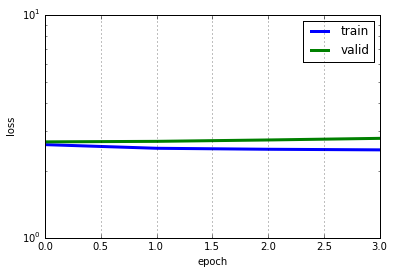

In [117]:
train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-0, 1e1)
plt.yscale("log")
plt.show()

# Looks pretty bad!

In [118]:
train_pred = net1.predict(np_train_data)
print(classification_report(train_labels_int, train_pred))
print 'The accuracy is:', accuracy_score(train_labels_int, train_pred)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1513
          1       0.18      0.02      0.03     76876
          2       0.00      0.00      0.00       406
          3       0.00      0.00      0.00       289
          4       0.10      0.00      0.00     36755
          5       0.00      0.00      0.00      4320
          6       0.00      0.00      0.00      2268
          7       0.33      0.04      0.07     53971
          8       0.00      0.00      0.00      4280
          9       0.00      0.00      0.00      1166
         10       0.00      0.00      0.00       256
         11       0.00      0.00      0.00       491
         12       0.00      0.00      0.00     10609
         13       0.00      0.00      0.00     16679
         14       0.00      0.00      0.00       146
         15       0.00      0.00      0.00      2341
         16       0.24      0.82      0.37    174900
         17       0.00      0.00      0.00   

In [151]:
# Tried a more complicated net with layers... still doing the same thing.
net2 = NeuralNet(
    layers=[  # more layers
        ('input', layers.InputLayer),
        ('dense0', layers.DenseLayer),
        ('dropout', layers.DropoutLayer),
        ('dense1', layers.DenseLayer),
        ('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, 7),  # 3 input pixels per batch
    dense0_num_units=10,  # number of units in hidden layer
    dropout_p=0.5,  # Not sure what this does.....
    dense1_num_units=10,  # number of units in hidden layer
    output_num_units=39,  # 39 target values
    output_nonlinearity=nonlinearities.softmax,

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.02,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=10,  # we want to train this many epochs
    verbose=1,
    )

net2.fit(train_data, train_labels)

# Neural Network with 619 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input         7
  1  dense0       10
  2  dropout      10
  3  dense1       10
  4  output       39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       4.14217       2.70658      1.53041      0.19904  2.46s
      2       2.64476       2.70492      0.97776      0.19904  2.82s
      3       2.64386       2.70447      0.97759      0.19904  2.76s
      4       2.64356       2.70428      0.97755      0.19904  2.82s
      5       2.64343       2.70418      0.97753      0.19904  2.74s
      6       2.64335       2.70412      0.97753      0.19904  2.90s
      7       2.64330       2.70408      0.97752      0.19904  2.99s
      8       2.64327       2.70406      0.97752      0.19904  2.91s
      9       2.64324       2.70404      0.97752      0.19904  2.77s
     10       2.64323    

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c727450>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c7273d0>,
     custom_score=None, dense0_num_units=10, dense1_num_units=10,
     dropout_p=0.5, input_shape=(None, 7),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('dense0', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout', <class 'lasagne.layers.noise.DropoutLayer'>), ('dense1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=10, more_params={},
     objective=<function objective at 0x10c72a938>,
     objective_loss_function=<function categorical_crossentropy at 0x10c645a28>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x1290f2d40>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x1290f2d88>],
     outp

____
____
____

Old code below here
____
____
____


In [109]:
np_train_data = np.array(pd.concat([data_XRs, data_YRs], axis=1))
num_features = np_train_data.shape[1]
#The accuracy is: 0.26692018327

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, num_features),  # 3 input pixels per batch
    hidden_num_units=500,  # number of units in hidden layer
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=39,  # 39 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.002,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

print np_train_data.shape
print train_labels.shape
#print len(train_data.columns)
net1.fit(np_train_data, train_labels_int)

(878049, 254)
(878049,)
# Neural Network with 147039 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input      254
  1  hidden     500
  2  output      39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.67321       2.66736      1.00219      0.20197  24.90s
      2       2.56639       2.64605      0.96990      0.20978  24.59s
      3       2.54176       2.63234      0.96559      0.21508  24.00s
      4       2.52726       2.62335      0.96337      0.21664  24.68s
      5       2.51784       2.61697      0.96212      0.21816  24.39s
      6       2.51080       2.61196      0.96127      0.22045  23.91s
      7       2.50493       2.60775      0.96057      0.22372  23.92s
      8       2.49969       2.60389      0.95998      0.22694  23.90s
      9       2.49486       2.60038      0.95942      0.22709  24.10s
     10       2.49034       2.59712

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c3cc1d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c3cc150>,
     custom_score=None, hidden_num_units=500, input_shape=(None, 254),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x10c3c5c80>,
     objective_loss_function=<function categorical_crossentropy at 0x10c1e2c80>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x112c910e0>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x113a6a950>],
     output_nonlinearity=<function softmax at 0x10c09c398>,
     output_num_units=39, regression=False,
     train_split=<nolearn.lasagne.base.TrainSplit objec

In [ ]:
      1       2.61487       2.69044      0.97191      0.20939  32.26s
      2       2.51820       2.70484      0.93099      0.20054  34.48s

In [11]:
#OLD - NOT USING Fit a basic RBM

#NNmodel = BernoulliRBM()
#NNmodel.fit(train_data, train_labels)


AttributeError: 'BernoulliRBM' object has no attribute 'predict'

In [7]:
# Convert to Numpy Format
# TODO: Add more features here
train_data = np.array(train[['DateDiff','X','Y']].values)
train_labels = np.array(train[['Category']].values.ravel())

dev_data = np.array(dev[['DateDiff','X','Y']].values)
dev_labels = np.array(dev[['Category']].values.ravel())

full_data = np.array(data[['DateDiff','X','Y']].values)
full_labels = np.array(data[['Category']].values.ravel())

test_data = np.array(test[['DateDiff','X','Y']].values)

# Normalize Data to Between 0-1
# a + (x-A)*(b-a)/(B-A) 
# TODO: Fix normalization to kick out "bad" x/y
train_normed = 0 + (np.abs(train_data) - np.abs(train_data).min(axis=0))*(1-0)/(np.abs(train_data).max(axis=0) - np.abs(train_data).min(axis=0)) 
dev_normed = 0 + (np.abs(dev_data) - np.abs(dev_data).min(axis=0))*(1-0)/(np.abs(dev_data).max(axis=0) - np.abs(dev_data).min(axis=0)) 

print train_normed.min(axis=0)
print train_normed.max(axis=0)

[ 0.  0.  0.]
[ 1.  1.  1.]


Code Below this point is from KNN - here to steal bits from while I work on NN.

In [9]:
# Use GridSearchCV to find a good number of neighbors.
#ks = {'n_neighbors': range(1,4)}
ks = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNNGridSearch = GridSearchCV(KNeighborsClassifier(), ks, scoring='f1_weighted')
KNNGridSearch.fit(train_data, train_labels)

# Report out on the accuracies    
print "The scores for each k value was %s " % (KNNGridSearch.grid_scores_)
print "The best k value was %s with accuracy %.4f" % (KNNGridSearch.best_params_, KNNGridSearch.best_score_)


The scores for each k value was [mean: 0.00303, std: 0.00382, params: {'n_neighbors': 1}, mean: 0.00314, std: 0.00389, params: {'n_neighbors': 2}, mean: 0.00300, std: 0.00380, params: {'n_neighbors': 3}, mean: 0.00302, std: 0.00378, params: {'n_neighbors': 4}, mean: 0.00299, std: 0.00371, params: {'n_neighbors': 5}, mean: 0.00300, std: 0.00373, params: {'n_neighbors': 6}, mean: 0.00297, std: 0.00372, params: {'n_neighbors': 7}, mean: 0.00297, std: 0.00371, params: {'n_neighbors': 8}, mean: 0.00295, std: 0.00369, params: {'n_neighbors': 9}, mean: 0.00295, std: 0.00368, params: {'n_neighbors': 10}] 
The best k value was {'n_neighbors': 2} with accuracy 0.0031


In [12]:
# Try k = 2
KNNmodel = KNeighborsClassifier(n_neighbors=1)
KNNmodel.fit(train_data, train_labels)
dev_predict = KNNmodel.predict(dev_data)
print "The KNN with DateDiff, X and Y (k=2) scores: {:.6f}".format(metrics.f1_score(dev_labels, dev_predict, average='weighted'))


# Tried a few tests (including the above). So far k=1 seems best.

The KNN with DateDiff, X and Y (k=2) scores: 0.220072


Great, now we've sorted out a naive alg to run. Let's train on all train, then predict on test

In [28]:
def create_submission(preds):
    labels = ["Id",
                "ARSON",
                "ASSAULT",
                "BAD CHECKS",
                "BRIBERY",
                "BURGLARY",
                "DISORDERLY CONDUCT",
                "DRIVING UNDER THE INFLUENCE",
                "DRUG/NARCOTIC",
                "DRUNKENNESS",
                "EMBEZZLEMENT",
                "EXTORTION",
                "FAMILY OFFENSES",
                "FORGERY/COUNTERFEITING",
                "FRAUD",
                "GAMBLING",
                "KIDNAPPING",
                "LARCENY/THEFT",
                "LIQUOR LAWS",
                "LOITERING",
                "MISSING PERSON",
                "NON-CRIMINAL",
                "OTHER OFFENSES",
                "PORNOGRAPHY/OBSCENE MAT",
                "PROSTITUTION",
                "RECOVERED VEHICLE",
                "ROBBERY",
                "RUNAWAY",
                "SECONDARY CODES",
                "SEX OFFENSES FORCIBLE",
                "SEX OFFENSES NON FORCIBLE",
                "STOLEN PROPERTY",
                "SUICIDE",
                "SUSPICIOUS OCC",
                "TREA",
                "TRESPASS",
                "VANDALISM",
                "VEHICLE THEFT",
                "WARRANTS",
                "WEAPON LAWS"
              ]
    head_str = ','.join(labels)

    num_cats = len(labels)
    
    # Make a dummy row to append to
    ids = np.arange(preds.shape[0])[np.newaxis].transpose()
    
    results = np.column_stack((ids, preds))

    # Write results to csv
    np.savetxt('sample.csv', results, fmt='%d', delimiter=',', header=head_str, comments='')

    return results

In [17]:
# Now that we've done this, let's run the KNN on the full train, apply to the test, then format.
KNNmodel = KNeighborsClassifier(n_neighbors=1)
KNNmodel.fit(full_data, full_labels)
dev_predict = KNNmodel.predict_proba(test_data).astype(int)

In [29]:
results = create_submission(dev_predict)

In [30]:
print results.shape

(884262, 40)
